# <center>Breast cancer survival prediction</center>

*Authors: Alexandre Marquis, Michael Resplandy, Gabriel Faivre, Hugo Stubler, Stéphane Béreux*

### Table of contents

1. [Introduction](#introduction)
    1. [Basic cellular biology concepts](#base_biology)
        1. [Genetic information](#genetic_information)
        2. [Transcriptome](#transcriptome)
        3. [Gene network](#gene_network)
    2. [Cancer](#cancer)
    1. [Survival analysis](#survival_analysis)
        1. [Censoring of the data](#censoring_of_the_data)
        2. [Computational specificity](#computational_specificity)
        3. [Advise for the challenge](#advise_for_the_challenge)
2. [Data exploration](#data_exploration)
    1. [Python requirements](#python_requirements)
    2. [Gather the data](#getting_data)
3. [Overview of the data](#overview_of_the_data)
4. [Survival analysis for a gene](#survival_analysis_for_a_gene)
    1. [A few definitions](#definitions)
    2. [The Kaplan-Meier estimator](#kaplan_meier)
    3. [The log-rank test](#log_rank_test)
5. [Feature design](#feature_design)
    1. [Identification of the cancer driver genes](#identification_of_the_cancer_driver_genes)
    2. [Considering the whole dataset](#considering_the_whole_dataset)
    3. [Comparing with the Cancer Gene Census database](#comparing_with_the_cancer_gene_census_database)
    4. [Leveraging the gene network topology](#leveraging_the_gene_network_topology)
6. [Metric](#metric)
7. [Baseline model](#baseline_model)
    1. [The Cox regression](#cox_regression)
5. [Submission](#submission)


## Introduction <a name="introduction"></a>

Breast cancer is one of the most common cancers and the second leading cause of cancer death among women in the United States. One in nine women will be diagnosed with breast cancer in her lifetime ([INCa avril 2016](https://www.ligue-cancer.net/article/26094_cancer-du-sein)). Approximately 70% of breast cancer patients are inoperable because of advanced tumor growth or bone metastasis [Min Tao et al.](https://pubmed.ncbi.nlm.nih.gov/21512769/). 

It is therefore crucial to be able to accurately diagnose the disease, and to better understand the aggravating factors. Here we propose to predict the survival based on the genetic factors of the tumour.

### Basic cellular biology concepts <a name="base_biology"></a>

The following explanation is deliberately simplified, and does not get bogged down in unnecessary biological details that are irrelevant to the challenge. 
It simply aims to present a schematic vision of the functioning of the majority of human cells*, which justifies the approach adopted in this challenge, and thus gives possible leads for the participants.

\**except in particular degenerated cells such as red blood cells...*

#### Genetic information <a name="genetic_information"></a>

The human being is made up of approximately $10^{13}$ cells. These cells are not immutable: on the contrary they are themselves living entities, which are born, live and die.

Each human cell has its genetic information contained in [DNA](https://en.wikipedia.org/wiki/DNA#Biological_functions), a molecule with excellent storage capacities thanks to its stability and its faithful transmission from the mother cell to the daughter cells. This information is divided into genes.

During its life, the cell is led to express part of this information (e.g. part of the genes), by translating it into molecular tools. 
The modalities of expression differ according to the genes, but for the vast majority, the beginning of the expression process is the same. 

#### Transcriptome <a name="transcriptome"></a>

To be expressed, each gene is first [transcribed](https://en.wikipedia.org/wiki/Transcription_(biology)) into multiple copies of itself, in the form of [RNA](https://en.wikipedia.org/wiki/RNA#Comparison_with_DNA) molecules (a molecule close to DNA). Each copy of RNA contains the same genetic information as the original gene, but in a more reactive (and therefore more ephemeral) form than DNA. This makes it more accessible for expression.

![central-dogma.png](img/central-dogma.png)

<center><u>Pipeline of the expression of the genetic information : transcription into RNA and translation into proteins</u></center>

*(from https://www.atdbio.com/)*

*(The further expression of the genetic information is beyond the scope of this challenge, but essentially consists of two possibilities: either the RNA molecule is directly used as a molecular tool, or an additional step takes place ([translation](https://en.wikipedia.org/wiki/Translation_(biology))) which translates the RNA molecule into a protein.)*

The expression of a gene is therefore controlled by the number of RNA copies produced for each gene. The set of RNA molecules in a cell is called the [transcriptome](https://en.wikipedia.org/wiki/Transcriptome). 
Here we (classically) propose to use the transcriptome as a proxy to infer the expression of each gene.

As you will see in the following part, the main difficulty of this challenge will be to reduce the dimension of the very high-dimensional transcriptomic data (expression data for more than 35000 genes), in order to accurately predict the survival time of breast cancer patients.

#### Genes network  <a name="gene_network"></a>

Genes can interact with each other, which mean that some genes will induce or inhibits the expression of other genes. [Inferring these relationships](https://en.wikipedia.org/wiki/Gene_regulatory_network) has been an active area of research, and the [results](https://www.researchgate.net/publication/8910145_Network_Biology_Understanding_The_Cell%27s_Functional_Organization) tend to show that this network is a [hierarchical scale-free network](https://en.wikipedia.org/wiki/Hierarchical_network_model), hence a rather sparse network containing only some highly connected nodes, surrounded by local dense clusters.

![hierarchical](img/hierarchical.jpg)
<center><u>Example of hierarchical scale-free network</u></center>

(from [Babarasi et Oltvai 2004](https://www.researchgate.net/publication/8910145_Network_Biology_Understanding_The_Cell%27s_Functional_Organization))

<div style="width: 100%;  padding-top:10px; padding-bottom:10px;border: 3px solid #A0A0A0; text-align: center;background: #EEE3E0;"> Leveraging this structure can be a possible lead to condense the information of the transcriptome, by trying to identify these clusters and these highly connected genes.</div>


### Cancer  <a name="cancer"></a>

During the life of the cell, its DNA can undergo mutations, which, if not corrected, are passed on to its descendants.
From cell generation to cell generation, the mutations accumulate until they alter the cell's functioning.
One of the possible consequences is that the cell escapes the control of the organism and starts to proliferate in an anarchic manner. The cell then becomes tumorous (or cancerous).

It occurs unfortunately rather frequently in the case of the breast cells, which we propose to study here.

The expression of genetic information in a cancerous cell is largely modified compared to that of healthy cells, and it is this parameter that interests us here (estimated using the transcriptome).

By comparing the transcriptome of many different cancer cells with those of healthy cells, researcher have  [shown](https://www.nature.com/articles/leu201119/) that the alteration of certain gene expressions leads preferentially to cancer :
- a gene which is over-expressed in a cancerous cell is called an *[oncogene](https://en.wikipedia.org/wiki/Oncogene)*.
- Conversely, a gene that is under-expressed in a cancer cell is called a *[tumour suppressor gene](https://en.wikipedia.org/wiki/Tumor_suppressor)*.

Together, these genes are known as the *cancer driver genes*.

<div style="width: 100%;  padding-top:10px; padding-bottom:10px;border: 3px solid #A0A0A0; text-align: center;background: #EEE3E0;"> Another way of reducing the high-dimensional transcriptomic data (instead of leveraging the gene network structure), is by identifying such cancer driver genes, and using them to predict the seriousness of the cancer.</div>

### Survival analysis <a name="survival_analysis"></a>

#### Censoring of the data <a name="censoring_of_the_data"></a>

*[Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis)* is a branch of statistics designed to model the life or activity time of a living being or device. Widely used in medicine and particularly in oncology, it allows to process data often *[censored](https://en.wikipedia.org/wiki/Censoring_(statistics))* over time. 

Censored data consist in data for which the observed event (e.g. death for this challenge) is only partially known. As far as oncology is concerned, it is inevitable that patients become out of reach or leave the study before the measured event (death), which leads to *right-censored* data. This means that a lower bound on the patient's life time is known, but not its exact value.

Usually, we make the assumption that 

Classic statistical tools such as regression are then poorly adapted and may underestimate the lifetimes studied (if they consider that the time at which the patient leave the study is its time of death).

#### Computational specificity <a name="computational_specificity"></a>

This is why many specific methods, often derived from classical statistical models, have been developed for survival analysis, and are notably implemented in the [```scikit-survival```](https://scikit-survival.readthedocs.io/en/latest/user_guide/index.html) or [```pysurvival```](https://square.github.io/pysurvival/) Python libraries.

They require specific datasets, including a supplementary vector compared to regular datasets. Indeed, in addition to a classical dataset with $n$ samples, containing the $d$-dimensional features in the matrix $X \in \mathbb{R}^{nd}$ and the associated target values in the vector $y \in \mathbb{R}^{n}$, a survival dataset includes a third information : $E \in \mathbb{R}^{n}$. This vector contains a boolean indicator for each sample, telling if the event has occured (e.g. the patient $i$ is dead $\iff E_{i} =1$) or not (e.g. the patient $j$ is censored $\iff E_{j} = 0$).

To summarize, for a dataset containing $n$ samples, whose features are $d$-dimensional :

| Data | Regular dataset | Survival dataset |
| :- | :-: | :-: |
| Features | $X \in \mathbb{R}^{nd}$ | $X \in \mathbb{R}^{nd}$ |
| Target   | $y \in \mathbb{R}^{n}$ | $y \in \mathbb{R}^{n}$ |
| Events   | $\emptyset$ | $E \in \mathbb{R}^{n}$ |

#### Advise for the challenge <a name="advise_for_the_challenge"></a>

You will be given $X_{\texttt{train}}$, $y_{\texttt{train}}$ and $E_{\texttt{train}}$, and you will have to build a regressor able to accurately predict $y_{\texttt{test}}$ given $X_{\texttt{test}}$. (You will not be given $E_{\texttt{test}}$, which is logical : imagine a patient asks you to predict how long she will survive given the transcriptome of her tumour; you wouldn't have the information $E$ regarding her.).

You can choose to ignore the information given by $E_{\texttt{train}}$ (or include it only in the design of the features). If you do so, you can then create a classic regressor, such as those provided by [```scikit-learn```](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning), which uses only $X_{\texttt{train}}$ and $y_{\texttt{train}}$.

Otherwise, you can choose to directly use a survival regressor as those provided by the precedently cited Python libraries, which takes into account $E_{\texttt{train}}$. *This is the recommended procedure*.

<p style="color:#C82801";><b>The aim of this challenge is not so much to develop a new model, <i>although this is possible for the participants who wish to do so,</i> but rather to overcome the curse of the dimension by <u>designing relevant features to reduce the dimension</u>, and using them with existant survival models.
</b></p>

Throughout this notebook, we will present some basic relevant statistical techniques for survival analysis that might be useful for the challenge. However, the real difficulty of this challenge does not lie in the design of a sophisticated survival model, but in that of reducing the dimension of the transcriptomic data, for which no knowledge of survival analysis is required.

### Data exploration <a name="data_exploration"></a>

#### Python requirements <a name="python_requirements"></a>

In order to collect and analyse the data, the following Python libraries are required :



In [1]:
with open('requirements.txt', 'r') as requirements:
    print(requirements.read())

# Generic requirements
numpy
pandas
scipy
sklearn
seaborn
matplotlib
tqdm

# Gather the data
mygene
xenaPython

# Survival analysis
scikit-survival

# Requierements for RAMP Studio
ramp-workflow

# Graph library
networkx


Which can be installed (under Linux) with :

In [2]:
%%capture
!pip install -r requirements.txt

In [3]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import probplot, pearsonr
from tqdm.notebook import tqdm
import random
%matplotlib inline

#### Gather the data <a name="getting_data"></a>

First, you have to download the data, by running :

In [4]:
!python download_data.py

/bin/bash: ligne 1: python : commande introuvable


Now we can load the data.

In [5]:
from problem import get_train_data, get_test_data
X_train, E_y_train = get_train_data()
X_test, E_y_test = get_test_data()

$E$ and $y$ are stored together. As only $y$ has to be predicted, let's separate ```E_y_train``` into ```E_train``` and ```y_train```.

In [6]:
E_train, y_train = E_y_train[:,0], E_y_train[:,1]
E_test, y_test = E_y_test[:,0], E_y_test[:,1]

Given $X$, $E$ and $y$, we are ready to take a closer look at the data.

### Overview of the data <a name="overview_of_the_data"></a>

In [7]:
print('The training dataset contains %i patients, %.2f percents of whom are censored.' % (len(y_train), 100 * (1 - E_train.sum() / len(E_train))))
print('The testing dataset contains %i patients, %.2f percents of whom are censored.' % (len(y_test),  100 * (1 - E_test.sum() / len(E_test))))

The training dataset contains 940 patients, 83.72 percents of whom are censored.
The testing dataset contains 236 patients, 82.63 percents of whom are censored.


This high rate of right-censored data makes it necessary to use the information provided by the censored samples.



Let's have a look at the survival data. First we look only at the patients for whom we know the time of death, i.e. that are not censored.

In [8]:
is_uncensored = E_train == 1

print('They are %i uncensored patients' % sum(is_uncensored))

They are 153 uncensored patients


We can display the survival time for these patients

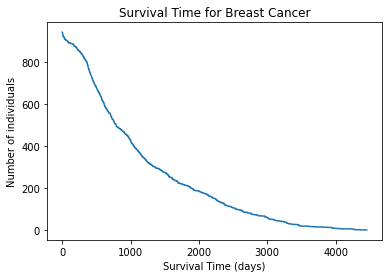

The survival time is included between 1 and 4456 days.


In [9]:
data_df = pd.DataFrame()
data_df['survival'] = y_train
r = range(np.max(data_df['survival']))
survival = [len(data_df['survival'].loc[data_df['survival'] > year]) for year in r]
plt.plot(r, survival)
plt.xlabel("Survival Time (days)")
plt.ylabel("Number of individuals")
plt.title("Survival Time for Breast Cancer")
plt.show()

print('The survival time is included between %.0f and %.0f days.' % (min(y_train), max(y_train)))

How many gene expression data are available for these patients ?

In [10]:
print('The features contain the expression data for %i genes.' % len(X_train.columns))

The features contain the expression data for 34794 genes.


This dataset is very high-dimensional : ```d``` $> 35$```n``` : it will obviously be necessary to drastically reduce the dimension of the features.

Let's take a closer look at the expression data.

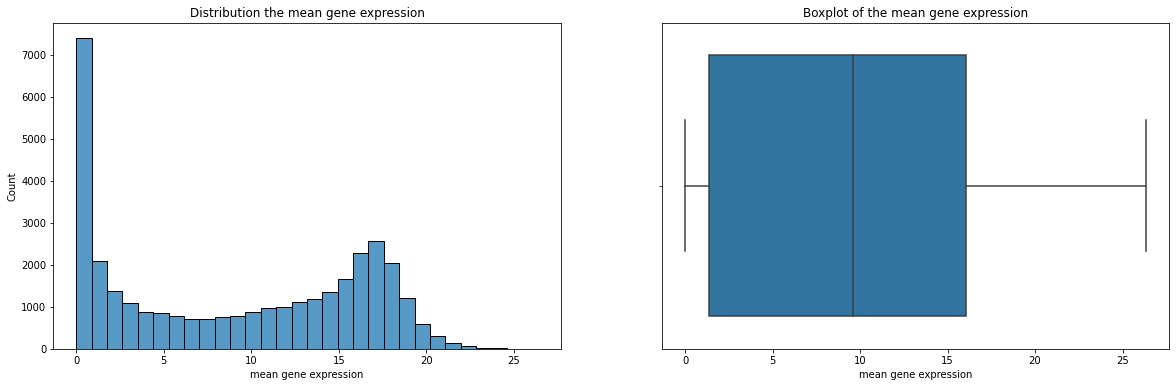

In [11]:
mean_x = X_train.mean()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

ax1.set_title('Distribution the mean gene expression')
ax1.set_xlabel('mean gene expression')
sns.histplot(mean_x, ax=ax1)


ax2.set_title('Boxplot of the mean gene expression')
ax2.set_xlabel('mean gene expression')
sns.boxplot(mean_x, ax=ax2)
plt.show()

We can see that many genes have almost zero expression (first column of the histogram). Let's investigate this column: maybe we can drop some of this data, and start to reduce the size of our data.

In [12]:
unexpressed_columns = X_train.columns[(mean_x == 0.).to_numpy()]
unexpressed_columns = [column.split('\n')[0] for column in unexpressed_columns]
print('We drop %i columns of genes which are never expressed.' % len(unexpressed_columns))
X_train.drop(columns=unexpressed_columns, inplace=True)

We drop 769 columns of genes which are never expressed.


### Survival analysis for a gene <a name="survival_analysis_for_a_gene"></a>

We will now present some tools for gene by gene survival analysis. In particular, the two tools that will be presented can be used to identify genes that particularly discriminate between patients, and use them as a feature for regression.

This list does not pretend to be exhaustive, but only to give some possible leads.

We will illustrate these tools with the gene [```MYC```](https://en.wikipedia.org/wiki/Myc), a well-known oncogene.

#### A few definitions <a name="definitions"></a>

To make this introduction to survival analysis more readable, we can assume that time is a discrete variable i.e $t \in \{1,...,n\}$ with $n \in \mathbb{N}$.

Let $ \tau \geq 0$ be the random variable giving the time before a relevant event happen. Usually, survival prediction aims to estimate the *survival function* $S$ which define  $\tau$, where $S$ is defined by :
$ {\displaystyle S(t)=\mathrm {Prob} (\tau >t)}$

However, we limit ourselves to predicting the life time of the patients. (It could for example be estimated from such a survival function by setting a threshold $d$ below which we consider that the patient dies. The life time of a patient would then be $argmax_{t} \text{  s.t.  } S(t) > d$)

We also make the (*very strong*) assumption that the censors (the patients leaving the study) are non-informative (e.g. they don't have anything to do with the subject studied, in other words they can be considered random).

#### The Kaplan-Meier estimator <a name="kaplan_meier"></a>

The Kaplan-Meier estimator is one of the most classic tool of survival analysis. Indeed, it is a non-parametric estimator (eg.g it does not make any assumption on the data distribution accross time), quite simple to implement, and it uses the information from the censored lineage.
The Kaplan-Meier estimator can be written : 
${\displaystyle {\hat{S}}(t)=\prod_{i:t_{i}\leq t}\left(1-{\frac{d_{i}}{n_{i}}}\right)}$. 
 
where $t_i$ is a time when at least one event happened, $d_i$ the number of event at time ${\displaystyle t_{i}}$ and $n_i$ the individuals still in the study (neither dead nor censored) at time $t_i$.

Intuitively, the product to compute ${\hat{S}}(t)$ is on all time less than t, and thus allows to take into account all patients, even those *censored* before time $t$ because they got out of the reach of the study.


Visually, a representation of a Kaplan-Meier estimator gives a decreasing staircase function, depicting an estimation of the survival function $S(t)$ ($S$ is supposed to be constant between two events).

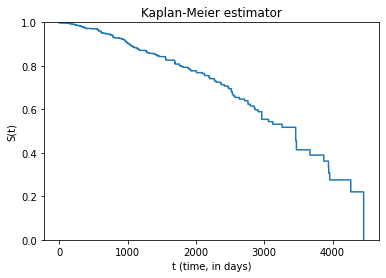

In [13]:
from sksurv.nonparametric import kaplan_meier_estimator 

x, y = kaplan_meier_estimator(E_train.astype(bool), y_train)
plt.xlabel('t (time, in days)')
plt.ylabel('S(t)')
plt.title('Kaplan-Meier estimator')
plt.step(x, y, where="post")
plt.ylim(0, 1)
plt.show()

By allowing to estimate the survival function of a sample, the Kaplan-Meier estimator enables the comparison between two different samples (for instance, if you are studying a gene $g$, you can set a threshold of expression $k$, and compare the patients with a gene expression lower than $k$ to the patients with a gene expression higher than $k$). 

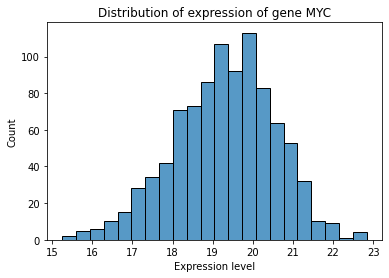

In [14]:
sns.histplot(X_train['MYC'].to_numpy())
plt.title('Distribution of expression of gene MYC')
plt.xlabel('Expression level')
plt.show()

We set the threshold to the mean, and create two subgroups :
+ the patients ```high_MYC``` with a high-level of ```MYC```, e.g. > 19.5
+ the patients ```low_MYC``` with a low-level of ```MYC```, e.g. < 19.5

Obviously, one could optimize the threshold to improve the separation between the two subgroups.

Threshold is equal to 19.292947


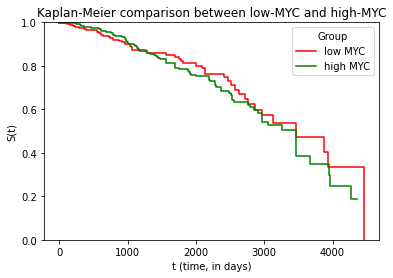

In [15]:
threshold = X_train['MYC'].to_numpy().mean()
print('Threshold is equal to %f' % threshold)

low_MYC = X_train[X_train['MYC'] < threshold].index
high_MYC = X_train[X_train['MYC'] > threshold].index

x_low, y_low = kaplan_meier_estimator(E_train.astype(bool)[low_MYC], y_train[low_MYC])
x_high, y_high = kaplan_meier_estimator(E_train.astype(bool)[high_MYC], y_train[high_MYC])
plt.xlabel('t (time, in days)')
plt.ylabel('S(t)')
plt.title('Kaplan-Meier comparison between low-MYC and high-MYC')
plt.step(x_low, y_low, where="post", color='r', label='low MYC')
plt.step(x_high, y_high, where="post", color='g', label='high MYC')
plt.ylim(0, 1)
plt.legend(title='Group')
plt.show()

This plot shows that a high expression of the MYC gene is unfavourable to the patient's prognosis. This is consistent with the classification of this gene as an oncogene.

But to compare the survival of different subgroups, other methods can be more appropriate.

#### The log-rank test <a name="log_rank_test"></a>

The log-rank test is a non-parametric hypothesis test allowing to compare the survival functions of two different populations. In practice, it's used to quantify the survival differences between two populations which can be observed by plotting their Kaplan-Meier estimation.

Indeed, the log-rank test also allows to take into account censored lineage without loosing to much information.

A few notations :

For each time j, we write $N_{{1j}}$ and $N_{{2j}}$ the number of patients from each group in each group still studied at time j, and $N_{j}=N_{{1j}}+N_{{2j}}$. Let's write $O_{{1j}}$ and $O_{{2j}}$ the number of events (e.g deaths) in each group happening at time j, and similarly $O_{j}=O_{{1j}}+O_{{2j}}$.

The idea of the log-rank test is to test the null hypothesis "the two population have the same survival function".

Under this hypothesis, $O_{1j}$ follows an hypergeometric law with parameters $N_j$, $N_{1j}$ and $O_j$, and thus with expectation $E_{1j}$ and variance $V_j$.

The convergence being garanteed by the Central Limit Theorem (Lyapunov version), we can define the random variable $${\displaystyle Z={\frac {\sum _{j=1}^{J}(O_{1j}-E_{1j})}{\sqrt {\sum _{j=1}^{J}V_{j}}}}{\xrightarrow {\mathbb{L}}\ N(0,1).}}$$

It is then easy to quantify the ressemblance between the law of $Z$ and a standard normal law to see if the null hypothesis can be rejected.

In [18]:
from sksurv.compare import compare_survival
from problem import to_structured_array

struct_E_y_train = to_structured_array(E_y_train)

# Encode the group membership : 1 = high_MYC, 0 = low_MYC
groups = np.ones(len(struct_E_y_train))
groups[low_MYC] = 0.

log_rank, p_value = compare_survival(struct_E_y_train, groups)
print('The difference of survival between the two laws is %.2f' % log_rank)

The difference of survival between the two laws is 0.16


### Feature design <a name="feature_design"></a>

As presented in the introduction, dimension reduction is at the heart of this challenge.

We will therefore illustrate the two approaches (which are of course not exhaustive) that we mentioned in the introduction.

Each of them is a research theme in itself: we do not pretend to explore them in a few lines of code. We merely sketch out possible directions for further research in order to design interesting features.

Moreover, we don't make use of the aforementioned tools for survival analysis, that could of course be combined with the following features to improve them.

#### Identification of the cancer driver genes <a name="identification_of_the_cancer_driver_genes"></a>

As presented in the introduction, a first idea would be to identify the *cancer driver genes*.

A possible approach to do so would be to select only those genes that are most correlated, in absolute terms, with survival time. In order to do so, we first work only with the uncensored data.  

We will apply Pearson correlation, but it relies on the assumption that the variable are a normally distributed, which is clearly not the case here, in particular for the ```time of survival```, as shown below. We therefore log-transform this variable.

In [19]:
X_uncensored = X_train[is_uncensored]
y_uncensored = y_train[is_uncensored]

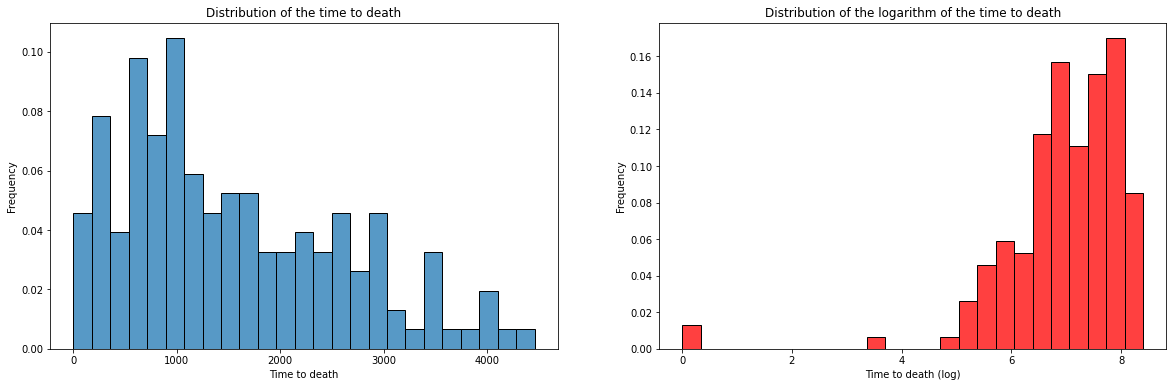

In [20]:
def display_time_to_death(y):
    """Compare the effect of the logarithm on the time."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    sns.histplot(y, ax=ax1, stat='probability',bins=25)
    ax1.set_title('Distribution of the time to death')
    ax1.set_xlabel('Time to death')
    ax1.set_ylabel('Frequency')

    log_time = np.log(y)
    sns.histplot(log_time, ax=ax2, stat='probability', color='r', bins=25)
    ax2.set_title('Distribution of the logarithm of the time to death')
    ax2.set_xlabel('Time to death (log)')
    ax2.set_ylabel('Frequency')
    plt.show()
    
display_time_to_death(y_uncensored)

The logarithmic transformation slightly improves the time distribution and makes it a little more normal.
Let's compute the correlation of the expression of each gene with the time to death.

In [21]:
def compute_correlations(X, y_log):
    """Compute the correlation and the associated p-values between the genes and the survival times."""
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X)
    gene_index, corr_r, p_values = [], [], []
    corr_df = pd.DataFrame(columns = {'genes', 'correlation', 'p_values'})
    for i, gene in enumerate(scaled_X.T):
        r, p_val = pearsonr(gene, log_time)
        if not math.isnan(r): # If the correlation is valid
            gene_index.append(X.columns[i])
            corr_r.append(r)
            p_values.append(p_val)
    
    corr_df = pd.DataFrame({'correlation' : corr_r, 
            'p_value' : p_values} , index = gene_index) 
    
    return corr_df


def display_correlations(corr_df):
    """Display the correlation and the p-values."""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
    
    sns.histplot(corr_df['correlation'].to_numpy(), ax=ax1, stat='probability')
    ax1.set_title('Distribution of the correlation between the genes expression and the time before death')
    ax1.set_xlabel('Correlation value')
    ax1.set_ylabel('Frequency')
    
    sns.histplot(corr_df['p_value'].to_numpy(), ax=ax2, stat='probability')
    ax2.set_title('Distribution of the p-values associated to correlations.')
    ax2.set_xlabel('p-values')
    ax2.set_ylabel('Frequency')
    
    probplot(corr_df['correlation'].to_numpy().flatten(), dist="norm",plot=ax3)
    ax3.set_title('QQ-plot between the normal distribution and the correlation distribution.')
    
    probplot(corr_df['p_value'].to_numpy().flatten(), dist="uniform", plot=ax4)
    ax4.set_title('QQ-plot between the uniform distribution and the p-values distribution.')
    
    plt.show()
    

/home/stephane/.local/lib/python3.9/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


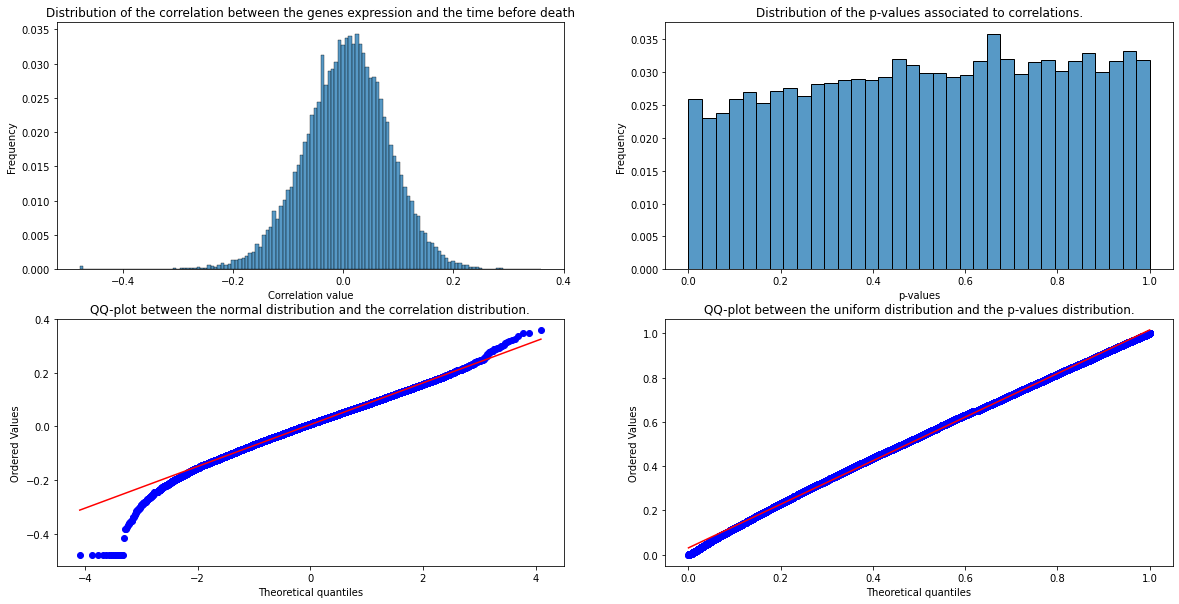

In [22]:
log_time = np.log(y_uncensored)
correlation_df = compute_correlations(X_uncensored, log_time)
display_correlations(correlation_df)

At first glance, the distribution of correlations seems close to the normal law... The comparison between the two laws can be refined by means of a Q-Q plot. It allows to compare graphically an empirical distribution with its theorical counterpart, by comparing their quantiles.

We expect the correlation values to be normally distributed if it is only a matter of chance. The associated p-values would then be uniformly distributed between 0 and 1. We thus compare the correlations (resp. p-values) distribution with the normal (resp. the uniform) distribution.

We thus observe an excess of genes correlated (in absolute value) with survival time compared to a distribution purely due to chance, which is encouraging : these highly correlated genes are good candidate to be cancer driver genes. (The positively correlated would thus be oncogenes and the negatively correlated would thus be tumour suppressor genes.)

Unfortunately, the distribution of p-values, which corresponds to the significance of the observed correlations, coincides rather well with a random distribution, which prevents us from selecting genes based on a reliable statistical way.

We can nevertheless select a first pool of genes (the top-correlated genes in absolute value), and use them as our first feature set : ```feature_1```.

In [23]:
correlation_threshold = 0.25
high_corr = correlation_df[np.abs(correlation_df['correlation']) > correlation_threshold]
high_correlation_genes = high_corr.index.to_numpy()
feature_1 = X_uncensored.filter(high_correlation_genes)
print('We keep %i genes.' % feature_1.shape[1])
feature_1.head()

We keep 124 genes.


,OR13K1P,AC013727.1,ALKBH1,SNRPGP13,ARL2BPP7,KRTAP21-1,MIR6766,NEFMP1,MIR5581,UBTFL5,...,MIR4418,MIR548AG2,TSPO2,COG4,RNA5SP328,AC006499.6,RNU6-38P,TFCP2,FERP1,KRTAP20-1
12,0.0,0.0,16.38,0.00,0.0,0.0,0.0,0.0,12.83,0.0,...,0.0,0.0,10.370,17.90,0.0,0.000,0.0,18.30,11.43,0.0
19,0.0,0.0,17.10,10.87,0.0,0.0,0.0,0.0,15.76,0.0,...,0.0,0.0,8.397,17.67,0.0,0.000,0.0,18.39,12.71,0.0
21,0.0,0.0,16.38,0.00,0.0,0.0,0.0,0.0,14.36,0.0,...,0.0,0.0,9.584,18.06,0.0,0.000,0.0,17.95,0.00,0.0
26,0.0,0.0,15.88,0.00,0.0,0.0,0.0,0.0,16.59,0.0,...,0.0,0.0,0.000,17.26,0.0,8.601,0.0,18.44,11.70,0.0
27,0.0,0.0,16.35,0.00,0.0,0.0,0.0,0.0,14.89,0.0,...,0.0,0.0,8.529,18.16,0.0,0.000,0.0,18.32,13.01,0.0


If we want to keep the genes based on a statistical criterion, we need to include the information of censored patients.

#### Considering the whole dataset <a name="considering_the_whole_dataset"></a>

As their censorship is independent of the survival time (by hypothesis), we can, as before, correlate their transcriptome with their survival time (although it is truncated for the censored patient). This should similarly allow us to isolate the cancer driver genes, and hopefully, with more data, to observe a deviation from the p-values distribution.

We thus proceed as precedently :

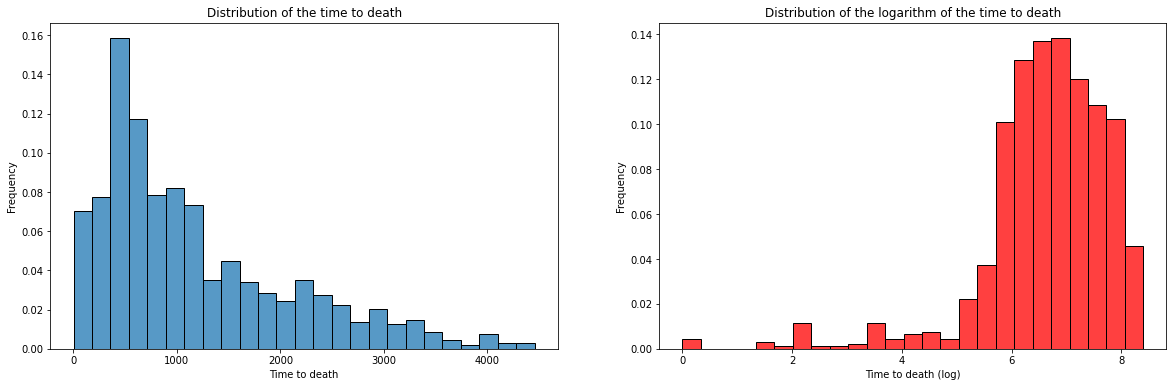

In [24]:
display_time_to_death(y_train)

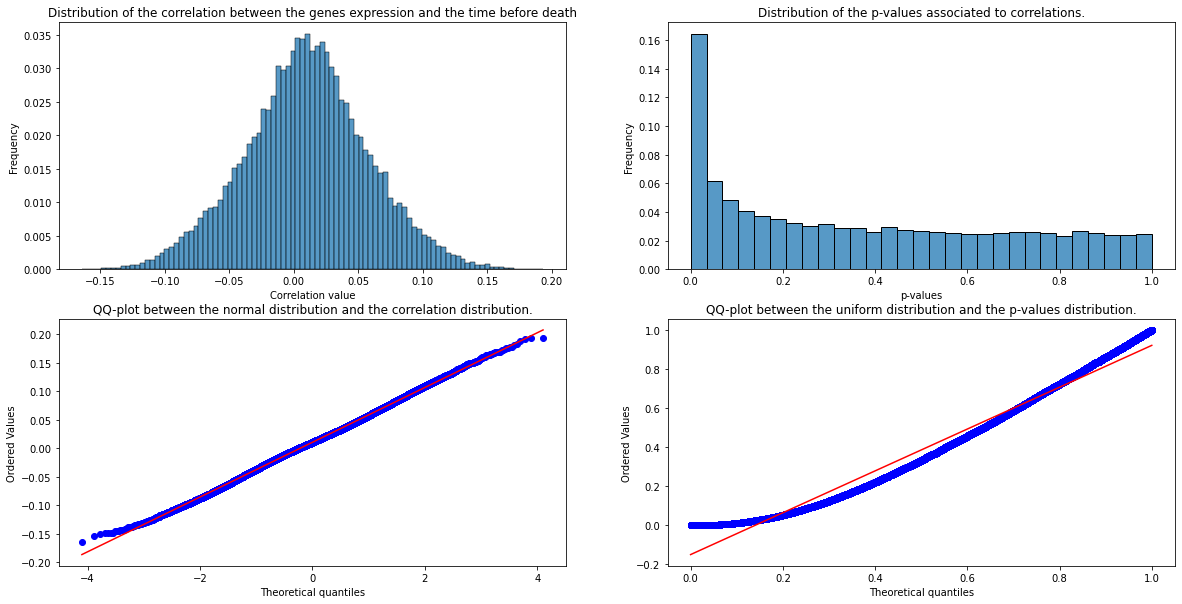

In [25]:
log_time = np.log(y_train)
correlation_df = compute_correlations(X_train, log_time)
display_correlations(correlation_df)

The p-values are not randomly distributed at all, and we observe in particular an enrichment in small p-values, which therefore correspond to significant correlations.

Let's extract the associated genes to create a second pool of features. We choose to keep the genes with a p-value < 0.05, i.e. with a 95% confidence interval.

But this lead to another question : how do we take into account the fact that we have tested a lot of different hypothesis ? Indeed, even if no gene has a effect on breast cancer mortality, we would still expect 5% of the 35000 genes to come out as significant with a confidence level of 0.05. This makes eventually 1750 false positive ! 

On the other hand, we know that some genes must have an effect, as the p-values we found by testing the genes one by one do not exhibit complete randomness, as shown in the above QQ-plot.

To overcome the issue of false positives, several multiple hypothesis correction exist, controlling either the *family-wise error rate*, that is the probability of keeping a gene which has no effect on the mortality, or the *false discovery rate*, controlling only the expected number of false discoveries.

The goal here being to identify relevant genes, in order to keep only relevant features, we have chosen to use the more conservative controls (the *family-wise error rate* controls). 
We thus choose a confidence level $\alpha = 0.05$ for the family-wise error rate, and we extract a group of genes such as the probability of making 0 type 1 error (saying there is an effect on mortality when there is none) is > 0.95.

We do this using the [*Bonferroni correction*](https://en.wikipedia.org/wiki/Bonferroni_correction). it consists of a strengthening of the restriction on the p-value:
if we want an $\alpha$-confidence level, and we test $m$ hypotheses (here $m$ = number of genes), then we only keep those with a p-value lower than $\frac{\alpha}{m}$, and create a second feature (```feature_2```) with them.

In [26]:
bonferroni_alpha = 0.05 / X_uncensored.shape[1]
print('The value of the Bonferroni correction is %f' % bonferroni_alpha)

The value of the Bonferroni correction is 0.000001


In [27]:
sign_corr = correlation_df[np.abs(correlation_df['p_value']) < bonferroni_alpha]
sign_correlation_genes = sign_corr.index.to_numpy()
feature_2 = X_train.filter(sign_correlation_genes)
print('We keep %i genes.' % feature_2.shape[1])
feature_2.head()

We keep 50 genes.


,KCNB1,RASA4,FAM107A,SOCS3,FOS,SAA1,SRL,CARF,ART4,ZFP36,...,SLC19A3,NR4A3,EGR1,AF001548.3,FLT3,N4BP2L1,SAA2,SELP,ATF3,HEPACAM
0,8.078,11.18,11.65,17.56,19.89,15.91,10.040,13.84,7.849,18.36,...,8.552,12.09,18.02,7.845,10.98,15.69,12.66,9.424,15.63,0.000
1,10.800,11.58,15.05,16.86,16.25,19.04,8.517,13.14,7.068,18.64,...,14.370,11.87,18.77,8.641,11.78,14.97,14.78,13.670,17.46,8.506
2,12.070,10.55,12.64,17.91,17.83,15.72,10.790,14.12,9.758,18.82,...,9.727,11.69,19.09,7.644,14.39,15.87,12.14,13.690,16.75,7.509
3,10.420,11.63,13.28,19.15,21.61,18.52,10.550,13.83,10.090,20.58,...,10.950,14.05,20.78,0.000,13.62,15.19,14.00,14.440,17.62,6.742
4,12.490,11.39,14.28,17.67,17.07,21.13,12.220,13.00,10.600,18.61,...,16.360,11.68,17.32,7.540,13.20,14.87,17.37,17.100,16.39,11.440


Alternatives to naïve Pearson's correlation are possible. In particular, the same procedure can be used with an univariate Cox Regression (see the baseline model), which can return the p-value associated to each feature (here, to each gene).
Selecting those with the lowest p-value has shown encouraging results.

#### Comparing with the Cancer Gene Census database <a name="comparing_with_the_cancer_gene_census_database"></a>

Statistical studies on the genes most frequently mutated in patients' tumours have made it possible to identify genes frequently mutated in cancer, and thus to create cancer driver genes databases.

Several lists exist: we provide one, extracted from the [CENSUS](https://cancer.sanger.ac.uk/census) database, one of the most widely used cancer driver genes databases. (We simplified the original database to retain only the list of the consensus genes, as well as a measure of our confidence in each of these genes).

In [28]:
from problem import get_census
census = get_census()

In [29]:
genes_consensus = set(census['Gene Symbol'].to_numpy())
print('The CENSUS database contains %i genes.' % len(genes_consensus))
common_genes = genes_consensus.intersection(set(X_train.columns))
print('%i are both part of the CENSUS database and of X_train.' % len(common_genes))

census.head()

The CENSUS database contains 723 genes.
698 are both part of the CENSUS database and of X_train.


,Gene Symbol,Tier
0,A1CF,2
1,ABI1,1
2,ABL1,1
3,ABL2,1
4,ACKR3,1


We don't have information on the whole genome for X_train, but "only" for the major part of it. That is why some genes from the CENSUS database are missing.

The column ```Gene Symbol``` provides the list of the genes, and the ```Tier``` is a measure of the confidence (the lower the better).

In [30]:
print('Tier can takes %i values :' % len(np.unique(census['Tier'].to_numpy())), np.unique(census['Tier'].to_numpy()))

Tier can takes 2 values : [1 2]


Let's compare the retained genes in ```feature_1``` and ```feature_2``` to the known cancer driver genes.

In [31]:
genes_feature_1 = set(feature_1.columns)
genes_feature_2 = set(feature_2.columns)

print('They are %i genes both in the Census database and in feature_1.' % len(genes_consensus.intersection(genes_feature_1)))
print('They are %i genes both in the Census database and in feature_2.' % len(genes_consensus.intersection(genes_feature_2)))

They are 0 genes both in the Census database and in feature_1.
They are 3 genes both in the Census database and in feature_2.


This comparison shows that the second approach, statistically reliable, seems to have slightly better results. However, both approachs seem to retain only very few known oncogenes. It is because it is very hard for a gene to be recorded in the Census database, and this database is thus highly incomplete. Moreover, the CENSUS database is based on mutated genes, while we are looking at gene expression.

This poor correspondance between our features and the known oncogenes is thus not alarming, and we will define a third feature, ```feature_3``` containing the genes from the CENSUS database.

In [32]:
feature_3 = X_train.filter(common_genes)

We can once more display the correlation and the associated p-values for each gene of ```feature_3```.

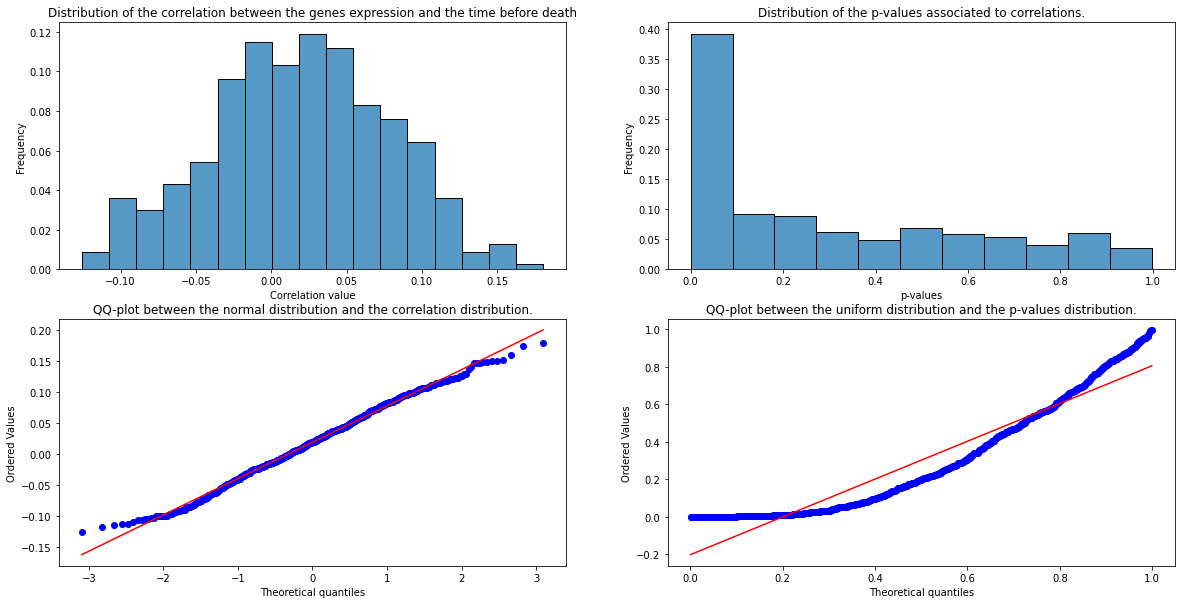

In [33]:
log_time = np.log(y_train)
correlation_df = compute_correlations(feature_3, log_time)
display_correlations(correlation_df)

####  Leveraging the gene network topology <a name="leveraging_the_gene_network_topology"></a>

Another way to represent the genes topology is to compute a graph based on the correlation between each gene. However, we cannot include all genes (the computation of the graph would take way to much time), so we need to define a treshold for the correlation and keep only the genes with a correlation superior to this treshold.
In order to do that, we first first computed the correlation between 1000 random genes and ploted the histogram, we then visualy assign the treshold (the treshold should depend on your computation power and your time available). We can see that the correlation matrix is then really sparse and will be more easy to manipulate.


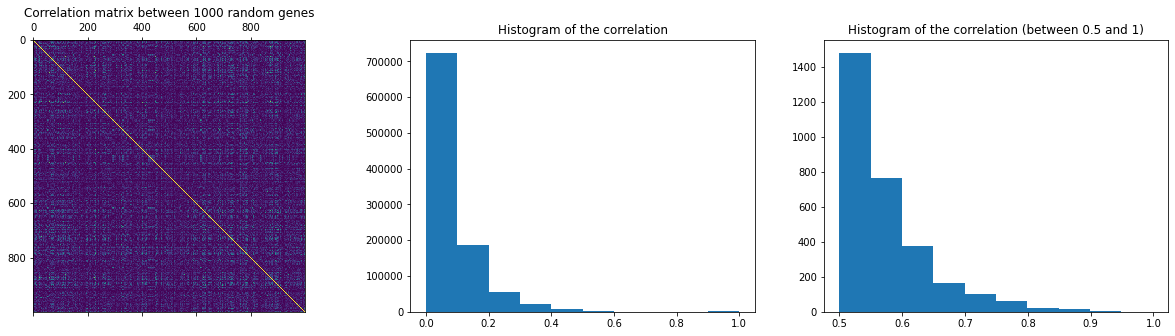

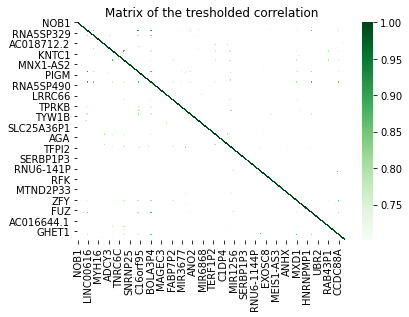

In [34]:
n_genes = 1000
random_genes = np.random.choice(X_train.columns, size=n_genes, replace=False)
corr = X_train[random_genes].corr().abs()

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,5))
ax1.matshow(corr)
ax1.set_title("Correlation matrix between 1000 random genes")

unstacked_corr = corr.unstack()
ax2.hist(unstacked_corr)
ax2.set_title("Histogram of the correlation")
ax3.hist(unstacked_corr, range=(0.5,0.999))
ax3.set_title("Histogram of the correlation (between 0.5 and 1)")
plt.show()

treshold = .7
corr_filtered = corr[corr>treshold]
sns.heatmap(corr_filtered, cmap="Greens")
plt.title("Matrix of the tresholded correlation")
plt.show()

Once we defined our treshold, we need to compute all the genes correlation, this step can take lot of time so we decided to restrain limit the number of genes observed, we selected all the genes from the census database and 1500 other random genes.

In [35]:
n_genes = 1500
recalculate_corrs = False
census_expression = census['Gene Symbol']
all_cols = set(X_train.columns)
set_census = all_cols.intersection(census_expression)

if recalculate_corrs:
    all_corr = pd.DataFrame()
    visited_cols = set()

    cols_census = list(set_census)
    cols_not_census = list(all_cols - set_census)
    random.shuffle(cols_not_census)

    cols =  cols_census + cols_not_census[0:n_genes]
    for col in tqdm(cols):
        visited_cols.add(col)
        corr = X_train[all_cols-visited_cols].corrwith(X_train[col]).abs()
        filtered_corr = corr[corr>0.1]
        filtered_corr_df = pd.DataFrame({'gene1': col,'gene2':filtered_corr.index, 'corr':filtered_corr.values})
        all_corr = all_corr.append(filtered_corr_df)
    all_corr.to_csv('data/corrs.csv', index=False) 

The next step is to represent this correlation as a graph. For this we use the library networkx wich is really powerful and simple to use. We first draw the graph and the subgraph of genes in the census database (red) and genes outside of the database (blue).

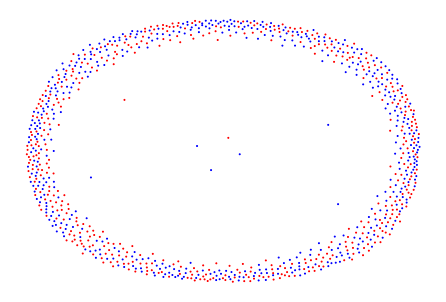

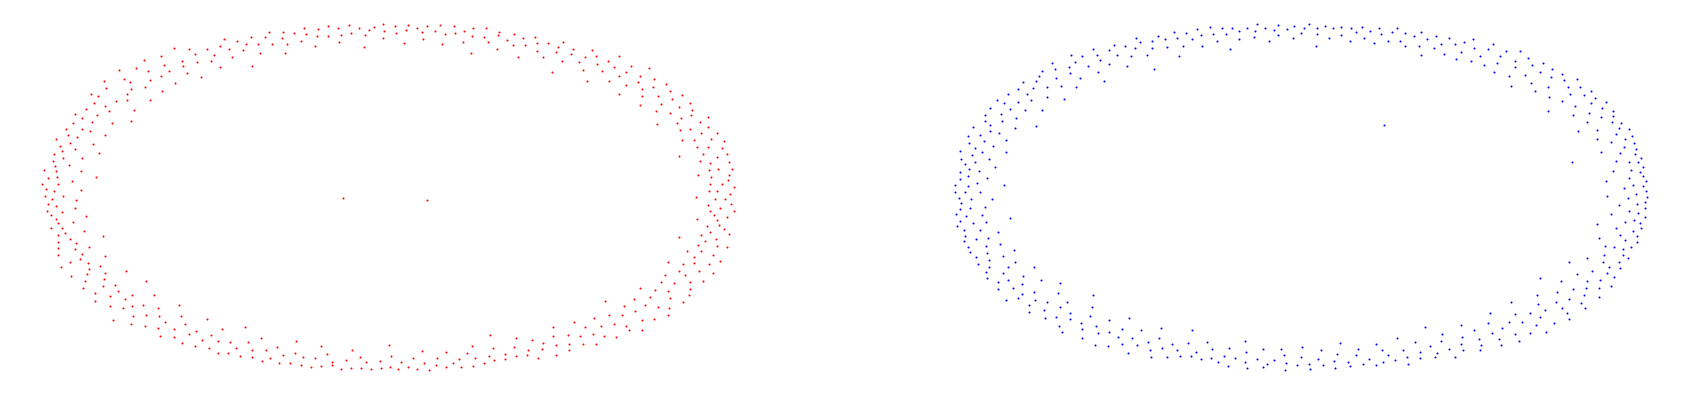

In [36]:
import networkx as nx

corrs = pd.read_csv('data/corrs.csv')
G = nx.from_pandas_edgelist(corrs, 'gene1', 'gene2', 'corr')

colors = []
census_graph = []
not_census_graph = []
for node in G.nodes:
    if node in set_census:
        colors.append('red')
        census_graph.append(node)
    else:
        colors.append('blue')
        not_census_graph.append(node)

nx.draw(G, node_size=1, node_color=colors, width=0.1)
plt.show()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(30,7))
nx.draw(G.subgraph(census_graph), node_size=1, width=0.1, ax=ax1, node_color= 'red')
nx.draw(G.subgraph(not_census_graph), node_size=1,width=0.1, ax=ax2, node_color='blue')
plt.show()

We can now try to find the communities in this graph, we will then try to find the communities which when it is expressed make the survivability vary the most, this community will be our selected fetures. In order to find the communities, we will use the Clauset-Newman-Moore greedy modularity maximization algorithm (implemented as the function greedy_modularity_communities) packaged with the networkx algorithm, some more powerful solution are possible but it is beyond the goal of this challenge.

In [37]:
from networkx.algorithms.community import greedy_modularity_communities

giant = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)
communities = list(greedy_modularity_communities(G))
print('Number of communities detected : ', len(communities))
df_train =  pd.DataFrame({ 'y' : y_train })
corr = np.array([])
for c, v_c in enumerate(communities):
    corr = np.append(corr, X_train[v_c].corrwith(df_train['y']).abs().mean())
best_communities = np.argsort(corr)[-22:]
features_graph = []
for c in best_communities:
    features_graph += list(communities[c])
features_graph = set(features_graph)
print("Number of features : ", len(features_graph))
feature_4 = X_train.filter(features_graph)

Number of communities detected :  972
Number of features :  22


### Metric <a name="metric"></a>
We will use the concordance index

In [38]:
from problem import ConcordanceIndex
ci = ConcordanceIndex()

### Baseline model <a name="baseline_model"></a>

#### The Cox regression<a name="cox_regression"></a>

The Cox regression is the equivalent of the logistic regression for survival analysis.
Let's define the *hazard rate*
$$\lambda(t)=\lim _{d t \rightarrow 0} \frac{\operatorname{Pr}(t \leq T<t+d t)}{d t \cdot S(t)}=-\frac{S^{\prime}(t)}{S(t)}$$
defined as the probability of dying at a certain time t given the fact that the patient survived until time t.
The Cox regression belong to the class of *proportional hazard models*, that is models which make the assumption that each unit increase for a covariate multiply the hazard rate of the patient by a fixed amount. For instance, taking a certain drug could halve the probability of dying from cancer at each time t.

This idea is formalized this way : 

Let $X_{i}=\left\{X_{i 1}, \ldots X_{i p}\right\}$ be the covariate values for a certain patient i.
Then we model the hazard rate $\lambda$ by 
<p style="color:#FF0000";>$${\lambda\left(t | X_{i}\right)=\lambda_{0}(t) \exp \left(\beta_{1} X_{i 1}+\cdots+\beta_{p} X_{i p}\right)=\lambda_{0}(t) \exp \left(X_{i} \cdot \beta\right)}$$</p>.

Let's  note that only the base hazard rate is time-dependant : the effect of each covariate on the *hazard rate* is assumed to be the same across time.

This property is the main "trick" of Cox regression : it allows to get rid of the hard-to-estimate hazard rate by taking a ratio. To be more precise, the likelihood of an event to be observed on patient i at time $Y_i$ is $$L_{i}(\beta)=\frac{\lambda\left(Y_{i} | X_{i}\right)}{\sum_{j : Y_{j} \geq Y_{i}} \lambda\left(Y_{i} | X_{j}\right)}=\frac{\lambda_{0}\left(Y_{i}\right) \theta_{i}}{\sum_{j : Y_{j} \geq Y_{i}} \lambda_{0}\left(Y_{i}\right) \theta_{j}}=\frac{\theta_{i}}{\sum_{j : Y_{j} \geq Y_{i}} \theta_{j}},$$ with $\theta_{j}=\exp \left(X_{j} \cdot\beta\right)$ and the summation being on all the patient still alive and in the study at time $Y_i$.

Skipping the most technical details, the idea is then to model all patients as independant and to maximize the product likekihood.

Here, we use the implementation from [```scikit-survival```](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.linear_model.CoxPHSurvivalAnalysis.html).

In [43]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


def get_unexpressed_columns(X_train):
    mean_x = X_train.mean()
    unexpressed_columns = X_train.columns[(mean_x == 0.).to_numpy()]
    unexpressed_columns = [column.split('\n')[0] for column in unexpressed_columns]
    return unexpressed_columns
    
    
class CoxRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        pca = PCA(n_components=10)
        regressor = CoxPHSurvivalAnalysis()
        self.regr = Pipeline([('pca', pca), ('regressor', regressor)])
        return 

    def fit(self, X, E_y=None):
        self.to_drop_columns = get_unexpressed_columns(X)
        X.drop(columns=self.to_drop_columns, inplace=True)
        struct_E_y = to_structured_array(E_y)
        self.regr.fit(X, struct_E_y)
        return self
    
    def predict(self, X):
        X.drop(columns=self.to_drop_columns, inplace=True)
        pdb.set_trace()
        risk_pred = self.regr.predict(X)
        y_pred = (max(risk_pred) + 1) - risk_pred
        return y_pred
    
    
class LinearRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        pca = PCA(n_components=10)
        regressor = LinearRegression(n_jobs=-1)
        self.regr = Pipeline([('pca', pca), ('regressor', regressor)])
        return 

    def fit(self, X, E_y=None):
        self.to_drop_columns = get_unexpressed_columns(X)
        X.drop(columns=self.to_drop_columns, inplace=True)
        
        y_to_predict = E_y[:,1] # We are only interested in predicting the survival time, not the censoring
        
        self.regr.fit(X, y_to_predict)
        return self
    
    def predict(self, X):
        X.drop(columns=self.to_drop_columns, inplace=True)
        return self.regr.predict(X)

Let's evaluate the model and compare it to a classic linear regressor. We use for this a PCA to reduce the number of features.

In [41]:
X_train, E_y_train = get_train_data()
X_test, E_y_test = get_test_data()

cox_regressor = CoxRegressor()
cox_regressor.fit(X_train, E_y_train)
y_pred = cox_regressor.predict(X_test)
cox_score = ci(E_y_test, y_pred)

linear_regressor = LinearRegressor()
linear_regressor.fit(X_train, E_y_train)
y_pred = linear_regressor.predict(X_test)
linear_score = ci(E_y_test, y_pred)

print('Performance of the linear model : %.3f\nPerformance of the Cox model : %.3f' %(linear_score, cox_score))

Performance of the linear model : 0.480
Performance of the Cox model : 0.541


We see that the linear model performs worse than a random regressor, while the Cox Regression performs significantly better. We will thus use it to compare the relevance of the different sets of features we designed.

In [45]:
from sklearn.compose import make_column_transformer

def get_feature(num_feature):
    genes_to_drop = []
     # select the genes to drop and record them in genes_to_drop ( a list with the column names)
    
    ### TODO
    if num_feature == 1:
        pass
    elif num_feature == 2:
        pass
    elif num_feature == 3:
        pass
    elif num_feature == 4:
        pass
    else:
        print('Only 4 different feature sets.')
    ### END TODO
        
    # Drop these columns
    feature_transformer = make_column_transformer(('drop', genes_to_drop), remainder='passthrough')
    return feature_transformer


class CoxRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, num_feature):
        feature_transformer = get_feature(num_feature)
        regressor = CoxPHSurvivalAnalysis()
        self.regr = Pipeline([('feature_transformer', feature_transformer), ('regressor', regressor)])
        return 

    def fit(self, X, E_y=None):
        struct_E_y = to_structured_array(E_y)
        self.regr.fit(X, struct_E_y)
        return self
    
    def predict(self, X):
        risk_pred = self.regr.predict(X)
        y_pred = (max(risk_pred) + 1) - risk_pred
        return y_pred

## Submission <a name="submission"></a>

You should implement a class ```Regressor``` in the file ```regressor.py```, provided in the ```starting_kit``` repository. This regressor should implement a ```predict``` method, which returns the survival time for each patient.

You can then test your submission by running the following command :

In [ ]:
!ramp-test --submission starting_kit

To submit your code, you can refer to the <a href="https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html">online documentation</a>.